In [118]:
import numpy as np
from sklearn.linear_model import LinearRegression
import scipy.stats as st
from scipy.stats import norm
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import theano.tensor as tt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams["figure.figsize"] = (6,3)

# Cumulative prospect theory


$$V(A) = \sum v(x_i)*\omega(p_i)$$

where $V(A)$ - value function, $\omega(p_i)$ - decision weights for for gains and losses


$$ v(x_i) = \begin{cases} 
    	x^{\alpha}, 
    	& \text{if}\, (x)>0 \\
    	-\lambda (-x)^{\alpha}, & \text{else}
    \end{cases}$$
$$ \omega(p) = \frac{p^{\gamma_{ind}}}{(p^{\gamma_{ind}} + (1-p)^{\gamma_{ind}})^1/\gamma_{ind}} $$
where $ind = +,\text{ if positive }, - \text{ else }$


Choice function:

$$\theta  = \frac{1}{1+e^{-\phi(V(A)-V(B))}}$$
A - Game, B - sure, in our case


### Risk-related parameters


 - $\lambda$ - The parameter reflects the relative
weighting of losses versus gains and is often found to be larger
than 1, indicating loss aversion.
 - $\delta_{+} (\delta_{-})$  - the parameters  (both >0) govern the elevations of the weighting function for
gains and losses, respectively, and can be interpreted as the
attractiveness of gambling. The elevation of the weighting
function thus also indicates a person’s risk attitude, with
higher (lower) values on $\delta_{+} (\delta_{-})$ representing higher risk
aversion in gains (losses; see Qiu & Steiger, 2011).

### Testosterone related parameters


Testing how testosterone influences on all risk-related parameters 

# Data

Data description:

Basic preprocessing steps

In [25]:
df = pd.read_csv('Framing.csv',sep = ';')
df.head(10)

,ID,T_W_0.9,PL_W_0.9,T_W_0.7,PL_W_0.7,T_W_0.5,PL_W_0.5,T_W_0.3,PL_W_0.3,T_W_0.1,...,T_L_0.9,P_L_0.9,T_L_0.7,PL_L_0.7,T_L_0.5,PL_L_0.5,T_L_0.3,P_L_0.3,T_L_0.1,P_L_0.1
0,PK01,2,1,1,1,1,1,1,1,1,...,2,1,2,1,1,1,1,1,1,2
1,PK02,2,2,2,2,2,1,1,1,1,...,1,1,1,1,1,2,2,1,2,2
2,PK03,2,1,1,1,1,1,1,1,1,...,1,2,1,2,1,2,1,2,1,2
3,PK04,2,1,2,2,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,2
4,PK05,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,2,1
5,PK06,1,2,1,2,1,2,1,1,1,...,1,1,1,1,1,1,1,2,2,2
6,PK07,1,2,2,2,1,2,1,1,1,...,1,1,1,1,2,2,2,2,2,2
7,PK08,2,2,2,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,2
8,PK09,1,1,2,1,2,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
9,PK10,2,2,2,2,1,2,1,2,1,...,1,1,1,1,1,2,2,2,2,2


In [63]:
m_df = pd.melt(df, id_vars='ID', value_vars=list(df.columns[1:]), value_name='Strategy')
m_df['Test'] = 1
m_df.loc[m_df['variable'].str.contains('P'),'Test'] = 0
m_df['Win'] = 1
m_df.loc[m_df['variable'].str.contains('_L'),'Win'] = 0
m_df['P'] = m_df.apply(lambda row: float(row.variable[-3:]), axis=1)
m_df.drop("variable", axis=1, inplace = True)
m_df.Strategy = m_df.Strategy - 1
win_money = {0.9: {'A': 2000, 'B': 1500}, 0.7: {'A': 500, 'B': 250}, 0.5: {'A': 1000, 'B': 500}, 
             0.3: {'A': 1500, 'B': 500}, 0.1: {'A': 250, 'B': 50}}
loss_money = {0.9: {'A': 2400, 'B': 1200}, 0.7: {'A': 600, 'B': 200}, 0.5: {'A': 1000, 'B': 500}, 
             0.3: {'A': 1800, 'B': 600}, 0.1: {'A': 1200, 'B': 400}}

m_df['A'] = 0
m_df['B'] = 1
m_df.loc[m_df['Win']== 1,'A'] = m_df.loc[m_df['Win']== 1].apply(lambda row: win_money[row.P]['A'], axis=1)
m_df.loc[m_df['Win']== 1,'B'] = m_df.loc[m_df['Win']== 1].apply(lambda row: win_money[row.P]['B'], axis=1)
m_df.loc[m_df['Win']== 0,'A'] = m_df.loc[m_df['Win']== 0].apply(lambda row: loss_money[row.P]['A'], axis=1)
m_df.loc[m_df['Win']== 0,'B'] = m_df.loc[m_df['Win']== 0].apply(lambda row: loss_money[row.P]['B'], axis=1)

m_df["Inds"] = pd.Categorical(m_df['ID']).codes
print(f'Number of inds: {len(pd.unique(m_df.Inds))}')
m_df.loc[m_df['Win']== 0,['A','B']] = -1*m_df.loc[m_df['Win']== 0,['A','B']]
m_df['GameId'] = 0    
grouped = m_df.groupby(['Win','P','Test'])
key_list = list(grouped.groups.keys())
for i,key in zip(range(len(key_list)),key_list):
    m_df.loc[grouped.groups[key_list[i]], 'GameId']  = i
    
m_df['TypeCode'] = 0
hormones = [0, 1, 0, 1]
win =  [1, 1, 0, 0]
codes = [0,1,2,3]
for c,h,w in zip(codes,hormones, win):
    m_df.loc[(m_df['Test']== h)&(m_df['Win']== w),'TypeCode']= c   
m_df.head()

Number of inds: 40


,ID,Strategy,Test,Win,P,A,B,Inds,GameId,TypeCode
0,PK01,1,1,1,0.9,2000,1500,24,19,1
1,PK02,1,1,1,0.9,2000,1500,25,19,1
2,PK03,1,1,1,0.9,2000,1500,26,19,1
3,PK04,1,1,1,0.9,2000,1500,27,19,1
4,PK05,0,1,1,0.9,2000,1500,28,19,1


## Utility function 


In [55]:
def value_f(x, alpha):
    """
    the power value function suggested by Tversky and Kahneman (1992)
    @param x: float, positive, money
    @param alpha: float, expected to be less then 1     
    """
    #val = tt.switch(tt.lt(x, 0),-tt.pow(-x, alpha),tt.pow(x, alpha))
    val  = tt.sgn(x)*tt.pow(tt.abs_(x),alpha)
    return val


def weights(p,c):
    """
    one-parameter weighting function used in Nilsson  
    @param p: float, real probability of gain or loss, should be in the interval (0,1) 
    @param c: float,the elevation of the weighting function, should be positive, expected in the interval (0,5) 
    
    @return: float, subjective probability of gain or loss, should be in the interval (0,1) 
    """
    numer = tt.pow(p,c)
    denom = tt.pow(tt.pow(p,c) + tt.pow(1-p,c),1/c)
    return numer/denom

def weights_numpy(p,c):
    """
    one-parameter weighting function used in Nilsson
    
    
    @param p: float, real probability of gain or loss, should be in the interval (0,1) 
    @param c: float,the elevation of the weighting function, should be positive, expected in the interval (0,5) 
    
    @return: float, subjective probability of gain or loss, should be in the interval (0,1) 
    """
    numer = np.power(p,c)
    denom = np.power(np.power(p,c) + np.power(1-p,c),1/c)
    return numer/denom
def value_numpy(x,alpha):
    return np.sign(x)*np.abs(x)**alpha
def gap(A, B, p, alpha, c):
    """
    Here for loss we also have positive values, so need to multiply gap value to -1 later
    
    compute subjective difference between two options: A (game), B (sure)
    @param A: float, positive, money, risk value
    @param B: float, positive, money, sure option
    @param alpha: float, expected to be less then 1  
    """
    val = value_f(A, alpha)*weights(p,c) - value_f(B, alpha)
    return val

## Models


 - model 0:  Only 1: win and 0:los (without hormones)
 
$$y_i \sim Binomial(1, p_i)$$
$$\theta = logit(p_i)  = \alpha_{cond} + \beta_{cond}*gap(A,B,alpha,c)$$
$$\alpha_{cond} = Normal(0,1, shape = 2)$$

$$\beta_{cond} = BoundedNormal(0.4,0.5, shape = 2)$$

 - model 1: 4 conditions 0: Win(Placebo), 1: Win(Test),2: Loss(Placebo), 3: Loss(Test)
 
 $$y_i \sim Binomial(1, p_i)$$
$$\theta = logit(p_i)  = \alpha_{cond} + \beta_{cond}*gap(A,B,alpha,c)$$
$$\alpha_{cond} = Normal(0,1, shape = 4)$$

$$\beta_{cond} = BoundedNormal(0.4,0.5, shape = 4)$$


In [137]:
def est_model_group(trace, model, df=None):
    est_df = df.copy()
    
    ppc = pm.sample_posterior_predictive(trace, samples=30, model=model)
    beta = st.beta((ppc['Strg'] == 1).sum(axis=0), (ppc['Strg'] == 0).sum(axis=0))
    est_df['Pred_lb'] = beta.interval(0.95)[0]
    est_df['Pred_ub'] = beta.interval(0.95)[1]
    est_df['Pred'] = ppc['Strg'].mean(axis=0)
    res = est_df.groupby('GameId')[['Pred','Strategy']].mean()

    res = est_df.groupby('GameId')[['Pred','Strategy', 'Pred_lb', 'Pred_ub']].mean()
    errs = (res['Pred_lb'].values.T,res['Pred_ub'].values.T)

    plt.plot(res.Strategy, res.Pred,'*',[0,1],[0,1]);
    plt.vlines(res.Strategy, *errs, colors='gray')
    
    regressor = LinearRegression(fit_intercept=False)
    regressor.fit(res.Strategy.values.reshape(-1,1), res.Pred.values.reshape(-1,1))
    print(f'R^2 value for real and predicted data: {regressor.score(res.Strategy.values.reshape(-1,1), res.Pred.values.reshape(-1,1)):.2f}')

    #plt.show()
    return est_df

In [148]:
chains = 4
N = len(pd.unique(m_df.Inds))

with pm.Model() as model_0:
    """
    model without any individual distinctions, without testosterone
    """
    #try with fixed value of alpha
    
    BoundedNormalI = pm.Bound(pm.Normal, lower=0.0, upper = 1.0)
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    
    #alpha = BoundedNormalI('alpha',mu = 0.8, sd=0.5, shape=2)
    alpha = 0.75
    #c = BoundedNormalI('c', mu = 0.7, sd = 0.2, shape=2)
    c = 0.89


    alpha_c = pm.Normal('alpha_c', 0, 1, shape = 2)
    beta_c = BoundedNormal('beta_c', 0.4,1, shape = 2)
    

    #Gap = gap(m_df.A, m_df.B, m_df.P, alpha[m_df.Win.values], c[m_df.Win.values]) #[m_df.Win.values]
    Gap = gap(m_df.A, m_df.B, m_df.P, alpha, c) #[m_df.Win.values]
    #Gap = pm.Deterministic('Gap', tt.sgn(Gap)*tt.log(1+tt.abs_(Gap)))
    Gap = tt.sgn(Gap)*tt.log(1+tt.abs_(Gap))
    
    theta = pm.math.invlogit(alpha_c[m_df.Win.values]+beta_c[m_df.Win.values]*Gap)
   
    strategy = pm.Binomial("Strg", 1, p=theta, observed=m_df.Strategy)
    trace_0 = pm.sample(3000, tune=500, target_accept=0.95, chains=chains)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_c, alpha_c]
Sampling 4 chains, 0 divergences: 100%|██████████| 14000/14000 [00:06<00:00, 2229.42draws/s]


In [149]:
az.waic(trace_0)

Computed from 12000 by 800 log-likelihood matrix

          Estimate       SE
elpd_waic  -409.66    14.48
p_waic        4.14        -

In [150]:
az.summary(trace_0,credible_interval=.89, round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha_c[0],-1.13,0.15,-1.36,-0.90,0.0,0.0,7277.16,7203.52,7314.14,8279.93,1.0
alpha_c[1],-1.02,0.13,-1.23,-0.81,0.0,0.0,10541.40,10163.14,10529.83,7474.86,1.0
beta_c[0],0.30,0.04,0.24,0.36,0.0,0.0,7852.97,7811.46,7869.97,8070.35,1.0
beta_c[1],0.37,0.05,0.30,0.45,0.0,0.0,9363.29,9363.29,9356.90,6761.71,1.0


/Users/irinaknyazeva/opt/anaconda3/envs/py36/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 30/30 [00:00<00:00, 882.48it/s]


R^2 value for real and predicted data: 0.75


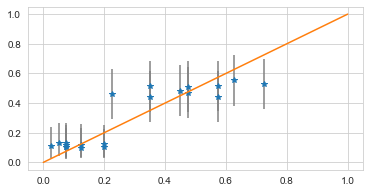

In [161]:
est = est_model_group(trace_0, model_0, m_df);

# More replication?
R^2 how good model data fit to real, 0.75 (perfect = 1)

In [162]:
chains = 4
N = len(pd.unique(m_df.Inds))

with pm.Model() as model_1:
    """
    model without any individual distinctions, without testosterone
    """
    #try with fixed value of alpha
    
    BoundedNormalI = pm.Bound(pm.Normal, lower=0.0, upper = 1.0)
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    
    #alpha = BoundedNormalI('alpha',mu = 0.8, sd=0.1, shape=4)
    #c = BoundedNormal('c', mu = 0.7, sd = 0.1, shape=4)
    alpha = 0.75
    c = 0.89

    alpha_c = pm.Normal('alpha_c', 0, 1, shape = 4)
    beta_c = BoundedNormal('beta_c', 0.4,0.5, shape = 4)
    

    #Gap = gap(m_df.A, m_df.B, m_df.P, alpha[m_df.Win.values], c[m_df.Win.values]) 
    #Gap = gap(m_df.A, m_df.B, m_df.P, alpha[m_df.TypeCode.values], c[m_df.TypeCode.values]) 

    Gap = gap(m_df.A, m_df.B, m_df.P, alpha, c) 
    Gap = tt.sgn(Gap)*tt.log(1+tt.abs_(Gap))
    
    theta = pm.math.invlogit(alpha_c[m_df.TypeCode.values]+beta_c[m_df.TypeCode.values]*Gap)
   
    strategy = pm.Binomial("Strg", 1, p=theta, observed=m_df.Strategy)
    trace_1 = pm.sample(3000, tune=200, target_accept=0.95, chains=chains)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_c, alpha_c]
Sampling 4 chains, 0 divergences: 100%|██████████| 12800/12800 [00:07<00:00, 1625.61draws/s]


In [163]:
az.waic(trace_1)

Computed from 12000 by 800 log-likelihood matrix

          Estimate       SE
elpd_waic  -410.68    14.73
p_waic        8.15        -

In [164]:
az.summary(trace_1, var_names = ['~Gap'],credible_interval=.89, round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha_c[0],-1.12,0.18,-1.40,-0.84,0.0,0.0,10794.78,10603.65,10810.31,8320.84,1.0
alpha_c[1],-0.90,0.19,-1.21,-0.60,0.0,0.0,13023.81,12665.82,13036.32,8994.26,1.0
alpha_c[2],-1.04,0.21,-1.37,-0.71,0.0,0.0,7522.85,7216.69,7641.63,7177.83,1.0
alpha_c[3],-1.20,0.21,-1.54,-0.88,0.0,0.0,10827.89,10490.53,10916.52,8924.54,1.0
beta_c[0],0.29,0.06,0.19,0.39,0.0,0.0,9166.20,9166.20,9014.25,6052.58,1.0
beta_c[1],0.46,0.07,0.36,0.57,0.0,0.0,11645.87,11645.87,11506.88,7702.19,1.0
beta_c[2],0.32,0.06,0.22,0.41,0.0,0.0,7974.87,7974.87,7953.18,7283.59,1.0
beta_c[3],0.29,0.06,0.20,0.38,0.0,0.0,8844.07,8844.07,8734.80,7091.51,1.0


/Users/irinaknyazeva/opt/anaconda3/envs/py36/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 30/30 [00:00<00:00, 904.57it/s]


R^2 value for real and predicted data: 0.83


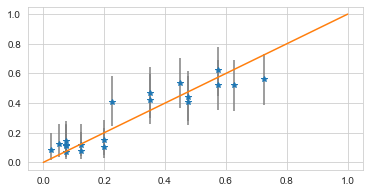

In [172]:
est = est_model_group(trace_1, model_1, m_df);

## Adding hormones didn't improve waic, but we better predict data, gain from 0.75 to 0.83 here

In [175]:
chains = 2
N = len(pd.unique(m_df.Inds))

with pm.Model() as model_2:
    """
    model without any individual distinctions, without testosterone
    """
    #try with fixed value of alpha
    
    BoundedNormalI = pm.Bound(pm.Normal, lower=0.0, upper = 1.0)
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    
    #alpha = BoundedNormalI('alpha',mu = 0.8, sd=0.1, shape=4)
    #c = BoundedNormal('c', mu = 0.7, sd = 0.1, shape=4)
    alpha = 0.75
    c = 0.89

    alpha_c = pm.Normal('alpha_c', 0, 1, shape = 4)
    beta_c = BoundedNormal('beta_c', 0.4,0.5, shape = 4)
    

    #Gap = gap(m_df.A, m_df.B, m_df.P, alpha[m_df.Win.values], c[m_df.Win.values]) 
    #Gap = gap(m_df.A, m_df.B, m_df.P, alpha[m_df.TypeCode.values], c[m_df.TypeCode.values]) 

    Gap = gap(m_df.A, m_df.B, m_df.P, alpha, c) 
    Gap = tt.sgn(Gap)*tt.log(1+tt.abs_(Gap))
    
    theta = pm.math.invlogit(alpha_c[m_df.TypeCode.values]+beta_c[m_df.TypeCode.values]*Gap)
   
    strategy = pm.Binomial("Strg", 1, p=theta, observed=m_df.Strategy)
    trace_2 = pm.sample(5000, tune=500, target_accept=0.95, chains=chains)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta_c, alpha_c]
Sampling 2 chains, 0 divergences: 100%|██████████| 11000/11000 [00:10<00:00, 1042.65draws/s]


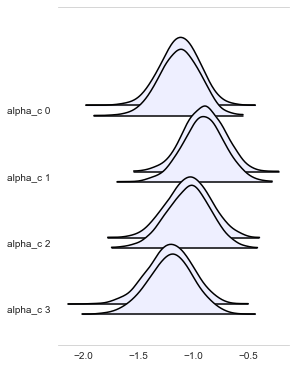

In [176]:
az.plot_forest(trace_2, var_names = ['alpha_c'], kind = 'ridgeplot', figsize=(4,5), colors='#eeefff', ridgeplot_overlap=3);

## alpha: shift to for sure option

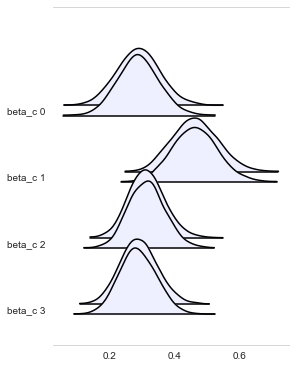

In [177]:
az.plot_forest(trace_2, var_names = ['beta_c'], kind = 'ridgeplot', figsize=(4,5), colors='#eeefff', ridgeplot_overlap=3);

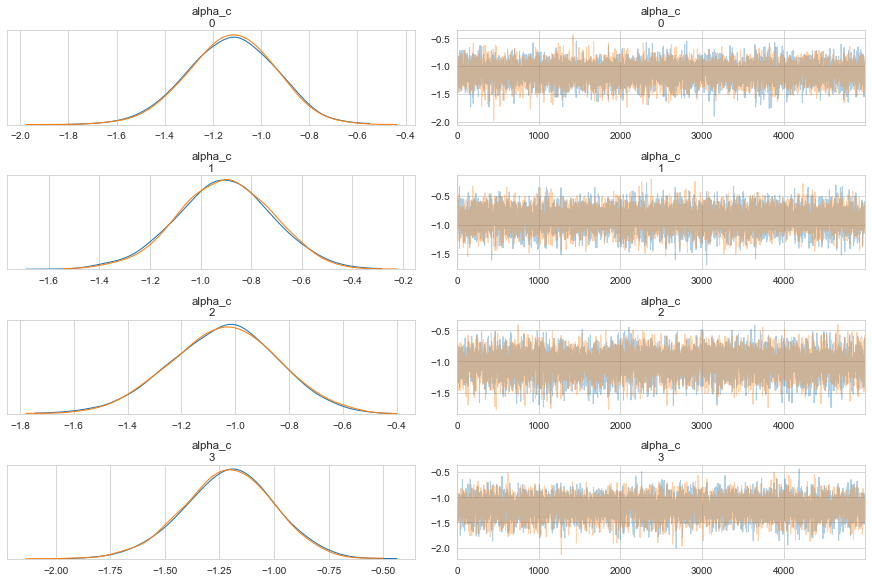

In [178]:
az.plot_trace(trace_2, var_names=('alpha_c'));

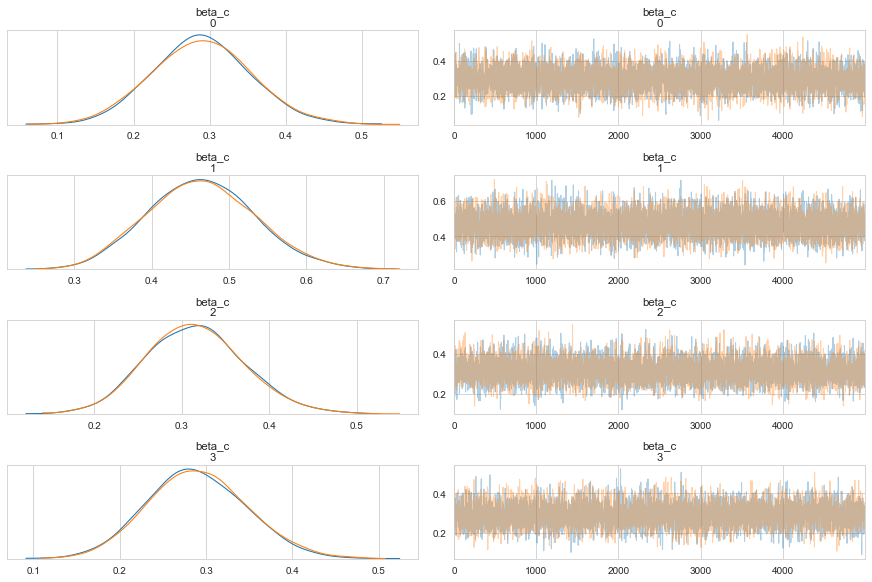

In [179]:
az.plot_trace(trace_2, var_names=('beta_c'));